# Exercise 4

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [2]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # TODO: set the model to train mode
    model.train()
    # If GPU should be used, move model to GPU
    if use_cuda:
        model.cuda()
    
    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    for batch_idx, (data, target) in enumerate(train_loader):
        
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        
        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()
        
        # TODO: run the network
        output = model(data)
        
        # TODO: compute negative log likelihood loss
        loss = F.nll_loss(output, target)
        
        # TODO: do backpropagation
        loss.backward()
        
        # TODO: optimize
        optimizer.step()
        
        # TODO: print current loss for every nth ("log_interval"th) iteration
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()))
        

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [3]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [4]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        # Define layers sequentially
        self.fc_layers = nn.Sequential(
            nn.Linear(784, 200),
            nn.Sigmoid(),
            nn.Linear(200, 100),
            nn.Sigmoid(),
            nn.Linear(100, 60),
            nn.Sigmoid(),
            nn.Linear(60, 30),
            nn.Sigmoid(),
            nn.Linear(30, 10)
        )

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(-1, 784)
        
        # TODO: run network layers
        x = self.fc_layers(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x, dim=1)
        
        return output

In [5]:
class FCNet2(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with ReLU non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet2, self).__init__()
        
        # Define layers sequentially with ReLU activation
        self.fc_layers = nn.Sequential(
            nn.Linear(784, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 60),
            nn.ReLU(),
            nn.Linear(60, 30),
            nn.ReLU(),
            nn.Linear(30, 10)
        )

    def forward(self, x):
        # Reshape batch of images to batch of 1D vectors
        x = x.view(-1, 784)
        
        # Pass through sequential layers
        x = self.fc_layers(x)
        
        # Compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [6]:
class FCNet3(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with ReLU non-linearity and batch normalization in the first and third layers
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet3, self).__init__()
        
        # Define layers sequentially with ReLU activation
        self.fc_layers = nn.Sequential(
            nn.Linear(784, 200),
            nn.BatchNorm1d(200),  # Batch normalization for the first layer
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 60),
            nn.BatchNorm1d(60),  # Batch normalization for the third layer
            nn.ReLU(),
            nn.Linear(60, 30),
            nn.ReLU(),
            nn.Linear(30, 10)
        )

    def forward(self, x):
        # Reshape batch of images to batch of 1D vectors
        x = x.view(-1, 784)
        
        # Pass through sequential layers
        x = self.fc_layers(x)
        
        # Compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [7]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        
        # TODO: initialize network layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2),
            nn.ReLU()
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 12 * 12, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.conv_layers(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(-1, 64 * 12 * 12)
        
        # TODO: run fully connected layers
        x = self.fc_layers(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [8]:
class ConvNet2(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet2, self).__init__()
        
        # Define layers sequentially
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),  # Batch normalization for the first convolutional layer
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2),
            nn.ReLU()
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 12 * 12, 128),
            nn.BatchNorm1d(128),  # Batch normalization for the first fully connected layer
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        # Run convolutional layers
        x = self.conv_layers(x)
        
        # Reshape batch of images to batch of 1D vectors
        x = x.view(-1, 64 * 12 * 12)
        
        # Run fully connected layers
        x = self.fc_layers(x)
        
        # Compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [9]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),  # Batch normalization for the first convolutional layer
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 12 * 12, 128),
            nn.BatchNorm1d(128),  # Batch normalization for the first fully connected layer
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        # Run convolutional layers
        x = self.conv_layers(x)
        
        # Reshape batch of images to batch of 1D vectors
        x = x.view(-1, 64 * 12 * 12)
        
        # Run fully connected layers
        x = self.fc_layers(x)
        
        # Compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

Train Epoch: 1 [0/60000]	Loss: 2.474828
Train Epoch: 1 [6400/60000]	Loss: 0.154933
Train Epoch: 1 [12800/60000]	Loss: 0.076955
Train Epoch: 1 [19200/60000]	Loss: 0.017449
Train Epoch: 1 [25600/60000]	Loss: 0.107632
Train Epoch: 1 [32000/60000]	Loss: 0.024435
Train Epoch: 1 [38400/60000]	Loss: 0.048859
Train Epoch: 1 [44800/60000]	Loss: 0.091586
Train Epoch: 1 [51200/60000]	Loss: 0.077082
Train Epoch: 1 [57600/60000]	Loss: 0.043413

Test set: Average loss: 0.0345, Accuracy: 9881/10000 (98.81%)



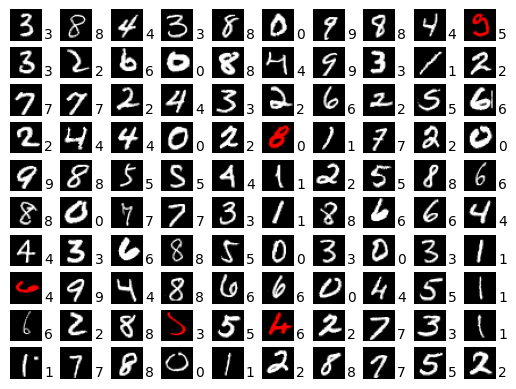

Train Epoch: 2 [0/60000]	Loss: 0.004931
Train Epoch: 2 [6400/60000]	Loss: 0.020368
Train Epoch: 2 [12800/60000]	Loss: 0.008612
Train Epoch: 2 [19200/60000]	Loss: 0.002966
Train Epoch: 2 [25600/60000]	Loss: 0.035166
Train Epoch: 2 [32000/60000]	Loss: 0.046496
Train Epoch: 2 [38400/60000]	Loss: 0.001670
Train Epoch: 2 [44800/60000]	Loss: 0.005886
Train Epoch: 2 [51200/60000]	Loss: 0.251218
Train Epoch: 2 [57600/60000]	Loss: 0.001726

Test set: Average loss: 0.0322, Accuracy: 9896/10000 (98.96%)



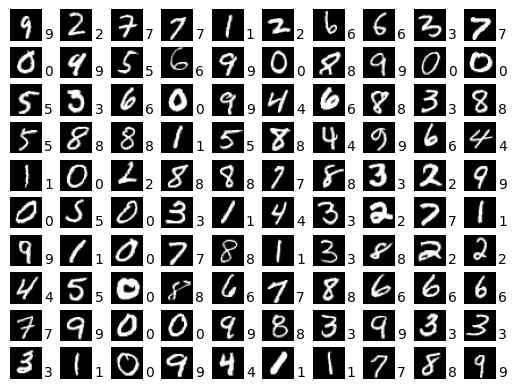

Train Epoch: 3 [0/60000]	Loss: 0.009035
Train Epoch: 3 [6400/60000]	Loss: 0.009072
Train Epoch: 3 [12800/60000]	Loss: 0.001775
Train Epoch: 3 [19200/60000]	Loss: 0.002223
Train Epoch: 3 [25600/60000]	Loss: 0.000462
Train Epoch: 3 [32000/60000]	Loss: 0.001234
Train Epoch: 3 [38400/60000]	Loss: 0.008328
Train Epoch: 3 [44800/60000]	Loss: 0.002037
Train Epoch: 3 [51200/60000]	Loss: 0.015822
Train Epoch: 3 [57600/60000]	Loss: 0.001752

Test set: Average loss: 0.0259, Accuracy: 9910/10000 (99.10%)



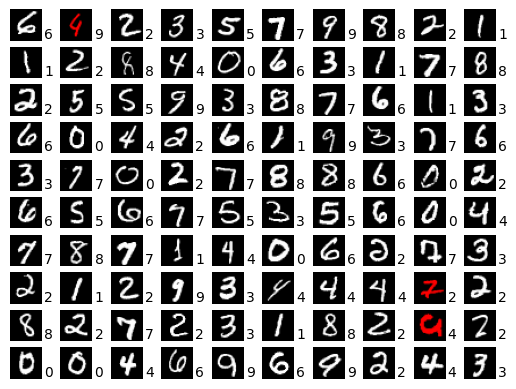

Train Epoch: 4 [0/60000]	Loss: 0.003581
Train Epoch: 4 [6400/60000]	Loss: 0.000454
Train Epoch: 4 [12800/60000]	Loss: 0.027092
Train Epoch: 4 [19200/60000]	Loss: 0.000574
Train Epoch: 4 [25600/60000]	Loss: 0.010233
Train Epoch: 4 [32000/60000]	Loss: 0.015334
Train Epoch: 4 [38400/60000]	Loss: 0.001069
Train Epoch: 4 [44800/60000]	Loss: 0.000992
Train Epoch: 4 [51200/60000]	Loss: 0.000625
Train Epoch: 4 [57600/60000]	Loss: 0.006627

Test set: Average loss: 0.0242, Accuracy: 9917/10000 (99.17%)



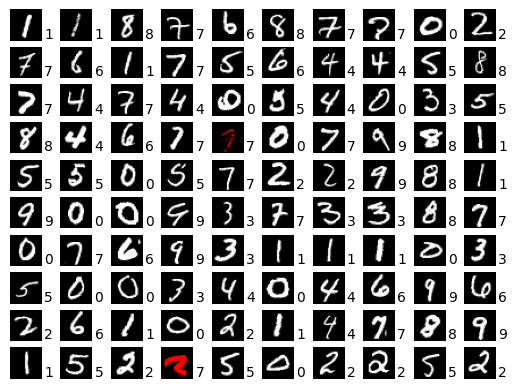

Train Epoch: 5 [0/60000]	Loss: 0.002099
Train Epoch: 5 [6400/60000]	Loss: 0.003005
Train Epoch: 5 [12800/60000]	Loss: 0.001126
Train Epoch: 5 [19200/60000]	Loss: 0.000238
Train Epoch: 5 [25600/60000]	Loss: 0.002017
Train Epoch: 5 [32000/60000]	Loss: 0.012380
Train Epoch: 5 [38400/60000]	Loss: 0.000202
Train Epoch: 5 [44800/60000]	Loss: 0.000482
Train Epoch: 5 [51200/60000]	Loss: 0.001660
Train Epoch: 5 [57600/60000]	Loss: 0.003187

Test set: Average loss: 0.0241, Accuracy: 9919/10000 (99.19%)



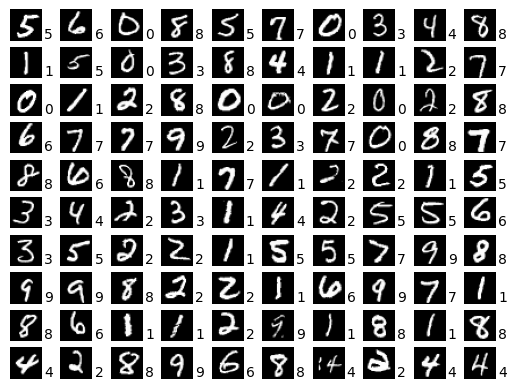

Train Epoch: 6 [0/60000]	Loss: 0.001349
Train Epoch: 6 [6400/60000]	Loss: 0.017178
Train Epoch: 6 [12800/60000]	Loss: 0.002354
Train Epoch: 6 [19200/60000]	Loss: 0.003170
Train Epoch: 6 [25600/60000]	Loss: 0.000495
Train Epoch: 6 [32000/60000]	Loss: 0.012159
Train Epoch: 6 [38400/60000]	Loss: 0.004093
Train Epoch: 6 [44800/60000]	Loss: 0.002901
Train Epoch: 6 [51200/60000]	Loss: 0.000539
Train Epoch: 6 [57600/60000]	Loss: 0.000810

Test set: Average loss: 0.0244, Accuracy: 9915/10000 (99.15%)



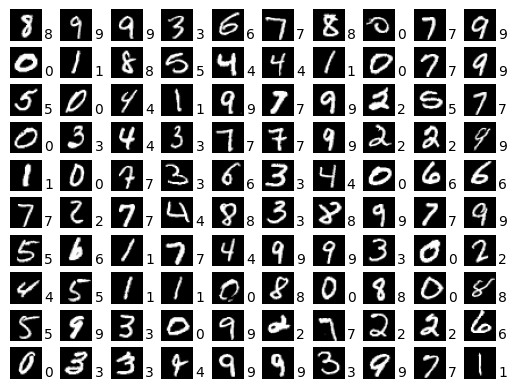

Train Epoch: 7 [0/60000]	Loss: 0.000744
Train Epoch: 7 [6400/60000]	Loss: 0.001185
Train Epoch: 7 [12800/60000]	Loss: 0.001078
Train Epoch: 7 [19200/60000]	Loss: 0.001305
Train Epoch: 7 [25600/60000]	Loss: 0.000981
Train Epoch: 7 [32000/60000]	Loss: 0.000950
Train Epoch: 7 [38400/60000]	Loss: 0.000861
Train Epoch: 7 [44800/60000]	Loss: 0.000244
Train Epoch: 7 [51200/60000]	Loss: 0.000913
Train Epoch: 7 [57600/60000]	Loss: 0.001168

Test set: Average loss: 0.0245, Accuracy: 9916/10000 (99.16%)



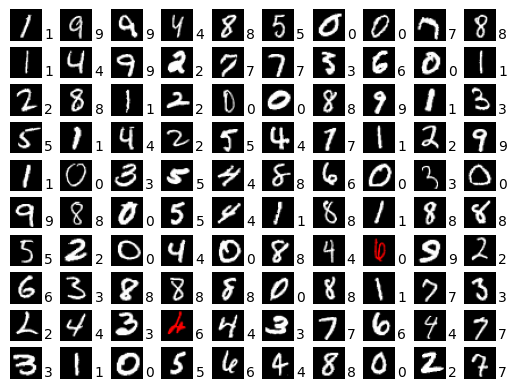

Train Epoch: 8 [0/60000]	Loss: 0.000797
Train Epoch: 8 [6400/60000]	Loss: 0.000698
Train Epoch: 8 [12800/60000]	Loss: 0.001057
Train Epoch: 8 [19200/60000]	Loss: 0.004734
Train Epoch: 8 [25600/60000]	Loss: 0.000835
Train Epoch: 8 [32000/60000]	Loss: 0.000249
Train Epoch: 8 [38400/60000]	Loss: 0.000523
Train Epoch: 8 [44800/60000]	Loss: 0.000423
Train Epoch: 8 [51200/60000]	Loss: 0.002249
Train Epoch: 8 [57600/60000]	Loss: 0.000456

Test set: Average loss: 0.0252, Accuracy: 9916/10000 (99.16%)



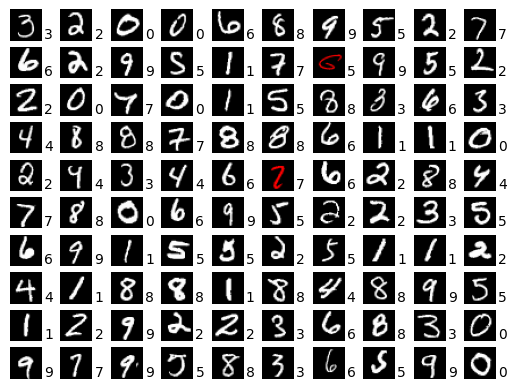

Train Epoch: 9 [0/60000]	Loss: 0.001769
Train Epoch: 9 [6400/60000]	Loss: 0.000682
Train Epoch: 9 [12800/60000]	Loss: 0.001777
Train Epoch: 9 [19200/60000]	Loss: 0.003150
Train Epoch: 9 [25600/60000]	Loss: 0.005150
Train Epoch: 9 [32000/60000]	Loss: 0.000422
Train Epoch: 9 [38400/60000]	Loss: 0.000372
Train Epoch: 9 [44800/60000]	Loss: 0.001851
Train Epoch: 9 [51200/60000]	Loss: 0.000690
Train Epoch: 9 [57600/60000]	Loss: 0.000262

Test set: Average loss: 0.0241, Accuracy: 9917/10000 (99.17%)



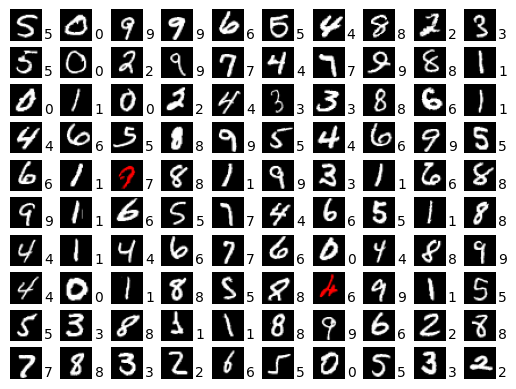

Train Epoch: 10 [0/60000]	Loss: 0.003880
Train Epoch: 10 [6400/60000]	Loss: 0.000073
Train Epoch: 10 [12800/60000]	Loss: 0.000164
Train Epoch: 10 [19200/60000]	Loss: 0.000317
Train Epoch: 10 [25600/60000]	Loss: 0.001173
Train Epoch: 10 [32000/60000]	Loss: 0.003686
Train Epoch: 10 [38400/60000]	Loss: 0.000224
Train Epoch: 10 [44800/60000]	Loss: 0.000287
Train Epoch: 10 [51200/60000]	Loss: 0.001812
Train Epoch: 10 [57600/60000]	Loss: 0.002248

Test set: Average loss: 0.0245, Accuracy: 9918/10000 (99.18%)



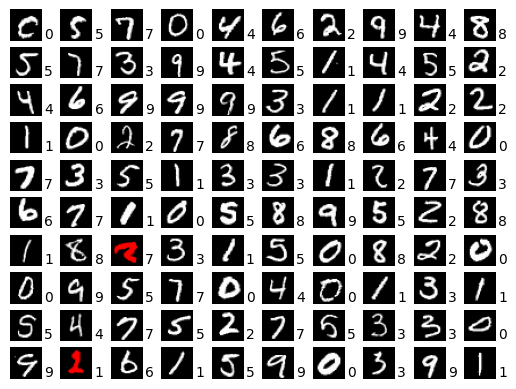

In [10]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = ConvNet3()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")